In [ ]:
import numpy as np 
import torch
import os 
import nltk
import random
import torch.cuda as cuda
import pickle
import matplotlib.pyplot as plt 
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # Show the GPU & CPU Specifications

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4277998501912663765
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15505193728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16789388713978804035
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]
Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/sentiment/vocab_new.txt", "rb") as fp:   
   vocab = pickle.load(fp)

with open("/content/drive/MyDrive/sentiment/train_data_indexed_new.txt", "rb") as fp:   
     train_data = pickle.load(fp)
with open("/content/drive/MyDrive/sentiment/validation_data_indexed_new.txt", "rb") as fp:  
   validation_data = pickle.load(fp)
with open("/content/drive/MyDrive/sentiment/test_data_indexed_new.txt", "rb") as fp:   
   test_data = pickle.load(fp)

with open("/content/drive/MyDrive/sentiment/train_lebel_new.txt", "rb") as fp:   
   train_label = pickle.load(fp)
with open("/content/drive/MyDrive/sentiment/validation_label_new.txt", "rb") as fp:  
   validation_label = pickle.load(fp)
with open("/content/drive/MyDrive/sentiment/test_label_new.txt", "rb") as fp:   
   test_label = pickle.load(fp)

seq_lenght = 244

In [ ]:
print("Vocab lenght is : ",len(vocab))
print("Vocab : \n",vocab)

Vocab lenght is :  63051
Vocab : 
 ['UNK', 'PAD', 'a', 'rant', 'by', 'any', 'other', 'name', ':', 'i', 'found', 'much', 'too', 'in', 'the', 'first', '2/3', 'of', 'book', 'and', 'would', 'have', 'put', 'it', 'down', 'except', 'we', 'agreed', 'to', 'read', 'for', 'group', '.', 'unless', 'you', 'are', 'really', 'ardent', 'environmentalist', 'willing', 'lay', 'your', 'life', 'pass', 'this', 'up', 'something', 'more', 'balanced', 'sensible', 'lasts', 'no', 'longer', 'than', 'one', 'year', 'actually', ',', 'is', 'third', 'rca', 'boom', 'box', 'model', 'that', 'purchased', 'because', 'they', 'relatively', 'inexpensive', 'my', 'local', 'target', 'carries', 'them', 'reason', 'however', 'three', 'after', 'either', 'tape', 'deck', 'or', 'cd', 'player', 'fails', 'use', 'daily', 'home', 'daycare', 'environment', 'but', 'children', 'do', 'not', 'operate', 'past', 'summer', 'dutifully', 'went', 'out', 'has', 'even', 'made', 'months', 'load', 'unexpectedly', 'clicks', 'off', 'running', 'only', 'few', 

In [ ]:
def return_batch(batch_number, mode = 'train'):
  if mode == 'train':
      X = torch.zeros((batch_size, seq_lenght))
      X[:,:] = torch.tensor(train_data[batch_size * batch_number : batch_size * (batch_number + 1)])

      Y = torch.zeros((batch_size, 1))
      Y[:,0] = torch.tensor(train_label[batch_size * batch_number : batch_size * (batch_number + 1)])

  elif mode == 'test':
      X = torch.zeros((batch_size, seq_lenght))
      X[:,:] = torch.tensor(test_data[batch_size * batch_number : batch_size * (batch_number + 1)])

      Y = torch.zeros((batch_size, 1))
      Y[:,0] = torch.tensor(test_label[batch_size * batch_number : batch_size * (batch_number + 1)])

  else:
      X = torch.zeros((batch_size, seq_lenght))
      X[:,:] = torch.tensor(validation_data[batch_size * batch_number : batch_size * (batch_number + 1)])

      Y = torch.zeros((batch_size, 1))
      Y[:,0] = torch.tensor(validation_label[batch_size * batch_number : batch_size * (batch_number + 1)])

  return X, Y


def shuffling_whole_date(X, Y):
  C = list(zip(X, Y))
  random.shuffle(C)
  X, Y = zip(*C)

  return list(X), list(Y)


def accuracy(output, y):
  #  output shape ->  torch : [batch_size, num_classes]
  #  y shape ->  torch : [batch_size,1]
  
  output = output.cpu().detach().numpy()
  #  output shape ->  numpy : [batch_size, num_classes]

  pred_classes = np.argmax(output, axis = 1) #  pred_classes -> numpy : [batch_size,]
  pred_classes = np.expand_dims(pred_classes, axis=1) #  pred_classes -> numpy : [batch_size,1]

  real_classes = y.cpu().detach().numpy()  #  real_classes  -> numpy : [batch_size,1]

  bool_array = (pred_classes==real_classes) # example: bool_array=[True, False, True, False, True]
  True_pred_counts = np.count_nonzero(bool_array) # count number of Trues in [True, False, True, False, True]
  
  return True_pred_counts/pred_classes.shape[0] # a digit 




In [ ]:
class encoder(torch.nn.Module):
  def  __init__(self, encoder_hidden_size, num_layer_enc, enc_bidirectional, emb_size):
    super().__init__()  
    self.lstm = torch.nn.LSTM(emb_size, encoder_hidden_size, num_layers = num_layer_enc, dropout = 0.4 ,bidirectional = enc_bidirectional)
    self.embedding = torch.nn.Embedding(len(vocab), emb_size)

  def forward(self, x, hidden, c): # seq_lenght is 244

    # x shape : torch.Size([seq_lenght, batch_size]) 
    # hidden shape :torch.Size([num_layers_enc * num_enc_direction, batch_size, hidden_size])
    # c shape :torch.Size([num_layers_enc * num_enc_direction, batch_size, hidden_size])
    
    emb = self.embedding(x.long())
    # emb shape : torch.Size([seq_lenght, batch_size, emb_size]) 

    out, (hidden, c) = self.lstm(emb, (hidden, c)) #  out = the toppest  hidden layer for all time steps |  hidden = contains all hiddens of last time step  |  c = contains all C of last time step
    
    # out shape :  torch.Size([seq_lenght, batch_size, hidden_size  * num_enc_direction])
    # hidden shape : torch.Size([num_layers_enc * num_enc_direction, batch_size, hidden_size])
    # c shape : torch.Size([num_layers_enc * num_enc_direction, batch_size, hidden_size])

    return out, hidden, c


In [ ]:

class encoder2decoder(torch.nn.Module):
  def  __init__(self, encoder_hidden_size, decoder_hidden_size, num_layer_enc, num_enc_directions):
    super().__init__()  
    self.fc = torch.nn.Linear(encoder_hidden_size * num_layer_enc * num_enc_directions, decoder_hidden_size)
    
    
  def forward(self, hidden): 
    # hidden shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) 
    
    hidden = torch.transpose(hidden, 0, 1)
    # hidden shape :   torch.Size([batch_size, num_enc_direction * num_layer_enc, encoder_hidden_size]) 

    hidden = hidden.reshape(batch_size, hidden.shape[1] * hidden.shape[2])    
    # hidden shape : torch.Size([batch_size, encoder_hidden_size * num_layer_enc * num_enc_directions]) 

    out= self.fc(hidden) 
    # out shape : torch.Size([batch_size, decoder_hidden_size])

    out =out.unsqueeze(0)
    # out shape : torch.Size([1, batch_size, decoder_hidden_size])

    return out


class decoder(torch.nn.Module):
  def  __init__(self, encoder_hidden_size, num_enc_direction, decoder_hidden_size, num_layer_dec, num_classes, dec_bidirectional):
    super().__init__() 

    self.lstm = torch.nn.LSTM(encoder_hidden_size*num_enc_direction, decoder_hidden_size, num_layers = num_layer_dec, bidirectional = dec_bidirectional)
    self.attn_alpha = torch.nn.Linear(decoder_hidden_size*2 + encoder_hidden_size * num_enc_direction, 1) # For generating alphas
    self.softmax = torch.nn.Softmax(dim = 1) 
    self.fc = torch.nn.Linear(decoder_hidden_size, num_classes)
 
    
  def forward(self, encoder_hiddens, hidden, c): # seq_lenght is 1 here (in decoder)

    # hidden shape :   torch.Size([1, batch_size, decoder_hidden_size]) 
    # c shape :   torch.Size([1, batch_size, decoder_hidden_size]) 
    # encoder_hiddens shape : torch.Size([encoder_seq_lenght, batch_size, encoder_hidden_size  * num_enc_directions]) | seq_lenght of encoder is 244

    encoder_seq_lenght = encoder_hiddens.shape[0]

    attn_weights = torch.zeros((batch_size, encoder_seq_lenght)) # [(batch_size, encoder_seq_lenght)]
    for i in range(encoder_seq_lenght):
      input = torch.cat((hidden[0,:,:],c[0,:,:],encoder_hiddens[i]),dim=1) # input : [(batch_size, decoder_hidden_size*2 + encoder_hidden_size  * num_directions_enc )]
      attn_weight = self.attn_alpha(input) # attn_weight : [(batch_size,1)]
      attn_weight = self.softmax(attn_weight)
      attn_weights[:,i] = attn_weight.squeeze(1)

    attn_weights = attn_weights.unsqueeze(2).double() # [(batch_size, encoder_seq_lenght, 1)]

    enc_hiddens = torch.transpose(encoder_hiddens, 1, 0) # ([batch_size, encoder_seq_lenght, encoder_hidden_size  * num_directions_enc])
    enc_hiddens = torch.transpose(enc_hiddens, 1, 2) # ([batch_size, encoder_hidden_size  * num_directions_enc, encoder_seq_lenght])
    
    if cuda.is_available():
       attn_weights = attn_weights.cuda()

    attn_applied = torch.bmm(enc_hiddens.double(), attn_weights)  # [(batch_size, encoder_hidden_size*num_directions_enc, 1)]  | alpha1 * h1 + alph2 * h2 + .... 
    attn_applied = attn_applied.squeeze(2) # [(batch_size, encoder_hidden_size*num_directions_enc)]
    attn_applied = attn_applied.unsqueeze(0) ## [(1, batch_size, encoder_hidden_size*num_directions_enc)] | 1 : decoder_seq_lenght
    
    x = attn_applied # [(1, batch_size, encoder_hidden_size*num_directions_enc)] | 1 : decoder_seq_lenght

    out, (hidden, c) = self.lstm(x, (hidden.double(), c.double()) ) #  out = the toppest  hidden layer for all time steps #  out = the toppest  hidden layer for all time steps |  hidden = contains all hiddens of last time step  |  c = contains all C of last time step
    # out shape :  torch.Size([seq_lenght, batch_size, dec_hidden_size  * num_dec_directions]) | 1 : decoder_seq_lenght 
    # hidden shape : torch.Size([num_dec_layers * num_dec_directions, batch_size, dec_hidden_size])
    # c shape : torch.Size([num_dec_layers * num_dec_directions, batch_size, dec_hidden_size])
    output = out.view(out.size(0)* out.size(1),out.size(2))  # shape:  torch.Size([seq_lenght * batch_size, dec_hidden_size  * num_dec_directions])    
    output = self.fc(output) # torch.Size([seq_lenght * batch_size, num_classes]) | seq_lenght = 1

    
    return output


In [ ]:
num_classes = 2

batch_size =  64 
number_of_train_batches = int(len(train_data) / batch_size)
number_of_validation_batches = int(len(validation_data) / batch_size)
number_of_test_batches = int(len(test_data) / batch_size)

print("NUMBER oF Train BATCHES : {}".format(number_of_train_batches))
print("NUMBER oF Validation BATCHES : {}".format(number_of_validation_batches))
print("NUMBER oF Test BATCHES : {}".format(number_of_test_batches))

encoder_hidden_size = 16
num_layer_enc = 2
num_enc_direction = 2
enc_bidirectional = bool(num_enc_direction - 1)
emb_size = 16
enc = encoder(encoder_hidden_size, num_layer_enc, enc_bidirectional, emb_size)


decoder_hidden_size = 16
enc2dec = encoder2decoder(encoder_hidden_size,decoder_hidden_size, num_layer_enc, num_enc_direction)

num_layer_dec = 1
num_dec_direction = 1
dec_bidirectional = bool(num_dec_direction - 1)
dec = decoder(encoder_hidden_size, num_enc_direction, decoder_hidden_size, num_layer_dec, num_classes, dec_bidirectional)

enc.double()
dec.double()
enc2dec.double()


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(enc2dec.parameters()) + list(enc.parameters()) + list(dec.parameters()) ,lr=0.0005, weight_decay = 0.0001)

NUMBER oF Train BATCHES : 12187
NUMBER oF Validation BATCHES : 3437
NUMBER oF Test BATCHES : 6250


In [ ]:
best_val_loss = 1000

train_epoch_losses = []
train_epoch_accs = []
validation_epoch_losses = []
validation_epoch_accs = []

for epoch in range(30):

  ##### TRAINING #####
  enc.train()
  dec.train()
  enc2dec.train()

  train_losses = []
  train_accs = []

  train_data, train_label = shuffling_whole_date(train_data, train_label)
  ## train_data : 2d array -> [total number of train samples][seq_lenght]
  ## train_label : 2d array -> [total number of train samples][seq_lenght]

  for batch_number in range(number_of_train_batches):

    X, Y = return_batch(batch_number)
    ## X shape : torch (batch_size , seq_lenght) | seq_lenght is 244
    ## Y shape : torch (batch_size , 1)

    X = torch.transpose(X, 0, 1)
    ## X shape : torch (seq_lenght, batch_size) | seq_lenght is 244

    h0 = torch.zeros((num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size)).double()
    c0 = torch.zeros((num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size)).double()

    if cuda.is_available(): 
              X = X.cuda()
              Y = Y.cuda() 
              enc = enc.cuda() 
              dec = dec.cuda() 
              enc2dec = enc2dec.cuda() 
              h0 = h0.cuda() 
              c0 = c0.cuda() 


    encoder_hiddens ,encoder_last_h ,encoder_last_c = enc(X, h0, c0) # seq_lenght is 244
    # encoder_hiddens shape :  torch.Size([seq_lenght, batch_size, encoder_hidden_size*num_enc_direction]) | hidden of all time steps
    # encoder_last_h shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) | hidden of last time step
    # encoder_last_c shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) | C of last time step


    h = enc2dec(encoder_last_h)
    # h shape :   torch.Size([1, batch_size, decoder_hidden_size]) 

    c = enc2dec(encoder_last_c)
    # c shape :   torch.Size([1, batch_size, decoder_hidden_size]) 

    output = dec(encoder_hiddens ,h, c)
    # output shape :   torch.Size([batch_size, num_classes]) | num_classes : 2

    loss = criterion(output, Y[:,0].long())  # loss : torch.Size([]) a digit 
    acc = accuracy(output, Y)
    train_losses.append(loss.cpu().detach().numpy())
    train_accs.append(acc)

    optimizer.zero_grad()   
    loss.backward()
    optimizer.step()

  print("Train: Loss of epoch {} is : {}".format(epoch+1, np.mean(train_losses)))
  print("Train: Accuracy of epoch {} is : {}".format(epoch+1, np.mean(train_accs)))
  train_epoch_losses.append(np.mean(train_losses))
  train_epoch_accs.append(np.mean(train_accs))

  
##### VALIDATION #####

  enc.eval()
  dec.eval()
  enc2dec.eval()

  validation_losses = []
  validation_accs = []

  validation_data, validation_label = shuffling_whole_date(validation_data, validation_label)
  ## validation_data : 2d array -> [total number of validation samples][seq_lenght]
  ## validation_label : 2d array -> [total number of validation samples][seq_lenght]

  for batch_number in range(number_of_validation_batches):

    X, Y = return_batch(batch_number, 'validation')
    ## X shape : torch (batch_size , seq_lenght) | seq_lenght is 244
    ## Y shape : torch (batch_size , 1)

    X = torch.transpose(X, 0, 1)
    ## X shape : torch (seq_lenght, batch_size) | seq_lenght is 244

    h0 = torch.zeros((num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size)).double()
    c0 = torch.zeros((num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size)).double()

    if cuda.is_available(): 
              X = X.cuda()
              Y = Y.cuda() 
              enc = enc.cuda() 
              dec = dec.cuda() 
              enc2dec = enc2dec.cuda() 
              h0 = h0.cuda() 
              c0 = c0.cuda() 


    encoder_hiddens ,encoder_last_h ,encoder_last_c = enc(X, h0, c0) # seq_lenght is 244
    # encoder_hiddens shape :  torch.Size([seq_lenght, batch_size, encoder_hidden_size*num_enc_direction]) | hidden of all time steps
    # encoder_last_h shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) | hidden of last time step
    # encoder_last_c shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) | C of last time step


    h = enc2dec(encoder_last_h)
    # h shape :   torch.Size([1, batch_size, decoder_hidden_size]) 

    c = enc2dec(encoder_last_c)
    # c shape :   torch.Size([1, batch_size, decoder_hidden_size]) 

    output = dec(encoder_hiddens ,h, c)
    # output shape :   torch.Size([batch_size, num_classes]) | num_classes : 2

    loss = criterion(output, Y[:,0].long())  # loss : torch.Size([]) a digit 
    acc = accuracy(output, Y)
    validation_losses.append(loss.cpu().detach().numpy())
    validation_accs.append(acc)


  print("Validation: Loss of epoch {} is : {}".format(epoch+1, np.mean(validation_losses)))
  print("Validation: Accuracy of epoch {} is : {}".format(epoch+1, np.mean(validation_accs)),end="\n")
 
  validation_epoch_losses.append(np.mean(validation_losses))
  validation_epoch_accs.append(np.mean(validation_accs))

  if np.mean(validation_losses)  <   best_val_loss:
    torch.save(enc.state_dict(), "/content/drive/MyDrive/sentiment/enco.pth")
    torch.save(dec.state_dict(), "/content/drive/MyDrive/sentiment/deco.pth")
    torch.save(enc2dec.state_dict(), "/content/drive/MyDrive/sentiment/enco2deco.pth")

    best_val_loss = np.mean(validation_losses)
    print("Saved! \n")
  print(" ---------------------------------------------- ")    


Train: Loss of epoch 1 is : 0.2852554088263426
Train: Accuracy of epoch 1 is : 0.8753230901780585
Validation: Loss of epoch 1 is : 0.1990293678182812
Validation: Accuracy of epoch 1 is : 0.9220886674425371
Saved! 

 ---------------------------------------------- 
Train: Loss of epoch 2 is : 0.18967289447422725
Train: Accuracy of epoch 2 is : 0.9259431156149995
Validation: Loss of epoch 2 is : 0.17982329394004065
Validation: Accuracy of epoch 2 is : 0.9301807535641547
Saved! 

 ---------------------------------------------- 
Train: Loss of epoch 3 is : 0.1743300613005069
Train: Accuracy of epoch 3 is : 0.9326331336670223
Validation: Loss of epoch 3 is : 0.1763087261844273
Validation: Accuracy of epoch 3 is : 0.9317537096304918
Saved! 

 ---------------------------------------------- 
Train: Loss of epoch 4 is : 0.16468057840048367
Train: Accuracy of epoch 4 is : 0.9367525334372693
Validation: Loss of epoch 4 is : 0.16334293486566043
Validation: Accuracy of epoch 4 is : 0.937399985452429

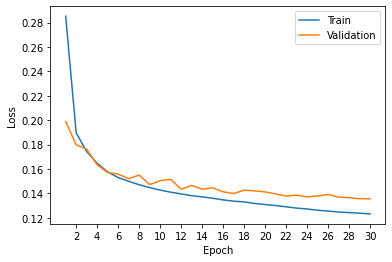

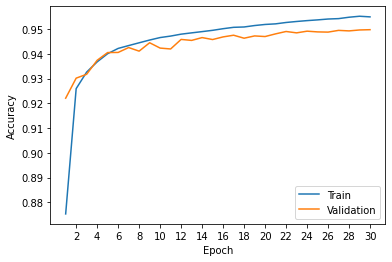

In [ ]:
xT = [int(2*i) for i in range(1,16)]

### Loss (plotting) 
x = [int(i+1) for i in range(len(train_epoch_losses))]
y = train_epoch_losses
plt.plot(x,y)
y = validation_epoch_losses
plt.plot(x,y)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(xT) 
plt.legend(["Train", "Validation"], loc ="upper right") 
plt.show()

print(" ")

### Accuracy (plotting) 
x = [int(i+1) for i in range(len(train_epoch_accs))]
y = train_epoch_accs
plt.plot(x,y)
y = validation_epoch_accs
plt.plot(x,y)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(xT) 
plt.legend(["Train", "Validation"], loc ="lower right") 
plt.show()


In [ ]:

enc.load_state_dict(torch.load("/content/drive/MyDrive/sentiment/enco.pth"))
dec.load_state_dict(torch.load("/content/drive/MyDrive/sentiment/deco.pth"))
enc2dec.load_state_dict(torch.load("/content/drive/MyDrive/sentiment/enco2deco.pth"))


<All keys matched successfully>

In [ ]:
  ##### TEST #####
  enc.eval()
  dec.eval()
  enc2dec.eval()

  test_losses = []
  test_accs = []

  test_data, test_label = shuffling_whole_date(test_data, test_label)
  ## test_data : 2d array  -> [total number of test samples][seq_lenght]
  ## test_label : 2d array -> [total number of test samples][seq_lenght]

  for batch_number in range(number_of_test_batches):

    X, Y = return_batch(batch_number, 'test')
    ## X shape : torch (batch_size , seq_lenght) | seq_lenght is 244
    ## Y shape : torch (batch_size , 1)

    X = torch.transpose(X, 0, 1)
    ## X shape : torch (seq_lenght, batch_size) | seq_lenght is 244

    h0 = torch.zeros((num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size)).double()
    c0 = torch.zeros((num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size)).double()

    if cuda.is_available(): 
              X = X.cuda()
              Y = Y.cuda() 
              enc = enc.cuda() 
              dec = dec.cuda() 
              enc2dec = enc2dec.cuda() 
              h0 = h0.cuda() 
              c0 = c0.cuda() 


    encoder_hiddens ,encoder_last_h ,encoder_last_c = enc(X, h0, c0) # seq_lenght is 244
    # encoder_hiddens shape :  torch.Size([seq_lenght, batch_size, encoder_hidden_size*num_enc_direction]) | hidden of all time steps
    # encoder_last_h shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) | hidden of last time step
    # encoder_last_c shape :   torch.Size([num_enc_direction * num_layer_enc, batch_size, encoder_hidden_size]) | C of last time step


    h = enc2dec(encoder_last_h)
    # h shape :   torch.Size([1, batch_size, decoder_hidden_size]) 

    c = enc2dec(encoder_last_c)
    # c shape :   torch.Size([1, batch_size, decoder_hidden_size]) 

    output = dec(encoder_hiddens ,h, c)
    # output shape :   torch.Size([batch_size, num_classes]) | num_classes : 2

    loss = criterion(output, Y[:,0].long())  # loss : torch.Size([]) a digit 
    acc = accuracy(output, Y)
    test_losses.append(loss.cpu().detach().numpy())
    test_accs.append(acc)

  print("Test: Loss is : {}".format( np.mean(test_losses)))
  print("Test: Accuracy is : {}".format(np.mean(test_accs)))


Test: Loss is : 0.13657252871766287
Test: Accuracy is : 0.94965
